In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import scipy.stats as stats
import missingno as msno

In [2]:
def show_full_data(data, row_size=None, column_size=None, col_width=-1):
    """Shows all rows and columns instead of showing only some part and hiding other parts for large data.
    """
    with pd.option_context('display.max_rows', row_size, 'display.max_columns', column_size, 'display.max_colwidth', col_width):
        display(data)

In [3]:
# Dataset directory
dir_loc = '../../../student-life-study-data/dataset/'

In [4]:
# Collecting all student codes from activity folder (which represents all students)
user_codes = []
for x in sorted(os.listdir(dir_loc + 'sensing/activity/')):
    # Chooses the string before "." and after "_"
    user_codes.append(x.split('.')[0].split('_')[1])

# Sensing

In [5]:
def get_activity(user):
    activity = pd.read_csv(dir_loc + 'sensing/activity/activity_' + user + '.csv')
    activity.columns = ['timestamp', 'activity_inference']
    # make timestamp unique and take the mode for different values of activity inference
    activity = activity.groupby("timestamp")['activity_inference'].apply(lambda x: x.mode()[0]).reset_index()
    activity.timestamp = pd.to_datetime(activity.timestamp, unit='s')
    activity = activity.set_index('timestamp')
    activity = activity.asfreq('s', method='bfill')
    return activity

def get_audio(user):
    audio = pd.read_csv(dir_loc + 'sensing/audio/audio_' + user + '.csv')
    audio.columns = ['timestamp', 'audio_inference']
    # make timestamp unique and take the mode for different values of audio inference
    audio = audio.groupby("timestamp")['audio_inference'].apply(lambda x: x.mode()[0]).reset_index()
    audio.timestamp = pd.to_datetime(audio.timestamp, unit='s')
    audio = audio.set_index('timestamp')
    audio = audio.asfreq('s', method='bfill')
    return audio

def get_conversation(user):
    conversation = pd.read_csv(dir_loc + 'sensing/conversation/conversation_' + user + '.csv')
    conversation.columns = ['start_timestamp', 'end_timestamp']
    conversation.start_timestamp = pd.to_datetime(conversation.start_timestamp, unit='s')
    conversation.end_timestamp = pd.to_datetime(conversation.end_timestamp, unit='s')
    return conversation

# def get_gps(user):
#     gps = pd.read_csv(dir_loc + 'sensing/gps/gps_' + user + '.csv', index_col=False)
#     gps.time = pd.to_datetime(gps.time, unit='s')
#     return gps

def get_bluetooth(user):
    bluetooth = pd.read_csv(dir_loc + 'sensing/bluetooth/bt_' + user + '.csv', index_col=False)
    bluetooth.time = pd.to_datetime(bluetooth.time, unit='s')
    return bluetooth
    
def get_wifi(user):
    wifi = pd.read_csv(dir_loc + 'sensing/wifi/wifi_' + user + '.csv', index_col=False)
    wifi.time = pd.to_datetime(wifi.time, unit='s')
    return wifi

def get_wifi_loc(user):
    wifi_loc = pd.read_csv(dir_loc + 'sensing/wifi_location/wifi_location_' + user + '.csv', index_col=False)
    wifi_loc.time = pd.to_datetime(wifi_loc.time, unit='s')
    return wifi_loc

def get_dark(user):
    dark = pd.read_csv(dir_loc + 'sensing/dark/dark_' + user + '.csv', index_col=False)
    dark.start = pd.to_datetime(dark.start, unit='s')
    dark.end = pd.to_datetime(dark.end, unit='s')
    return dark

def get_phone_charge(user):
    phonecharge = pd.read_csv(dir_loc + 'sensing/phonecharge/phonecharge_' + user + '.csv', index_col=False)
    phonecharge.start = pd.to_datetime(phonecharge.start, unit='s')
    phonecharge.end = pd.to_datetime(phonecharge.end, unit='s')
    return phonecharge

def get_phone_lock(user):
    phonelock = pd.read_csv(dir_loc + 'sensing/phonelock/phonelock_' + user + '.csv', index_col=False)
    phonelock.start = pd.to_datetime(phonelock.start, unit='s')
    phonelock.end = pd.to_datetime(phonelock.end, unit='s')
    return phonelock

In [6]:
u = 'u05'

In [7]:
activity = get_activity(u)
audio = get_audio(u)
conversation = get_conversation(u)
# gps = get_gps(u)
bluetooth = get_bluetooth(u)
wifi = get_wifi(u)
wifi_loc = get_wifi_loc(u)
dark = get_dark(u)
phone_charge = get_phone_charge(u)
phone_lock = get_phone_lock(u)

In [8]:
# activity - audio merge
df = pd.merge(activity, audio, left_index=True, right_index=True, how='outer')
df = df.reset_index()

In [9]:
# add conversation
df['conversation'] = np.nan
for i in range(conversation.shape[0]):
    start = conversation.iloc[i, 0]
    end = conversation.iloc[i, 1]
    df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'conversation'] = 1

In [10]:
# # add gps
# gps.columns = ['gps_' + i for i in gps.columns]
# df = df.reset_index()
# df = pd.merge(df, gps, left_on='timestamp', right_on='gps_time', how='outer')
# df.drop(columns=['gps_time'], inplace=True)

In [11]:
# add bluetooth
bluetooth_new = pd.DataFrame()
for time in bluetooth.time.unique():
    data = {'timestamp': time}
    item = bluetooth[bluetooth.time == time]
    data['total_devices_around'] = item.shape[0]
    data['total_nearer'] = item[item.level >= -70].shape[0]
    data['total_near'] = item[(item.level >= -80) & (item.level < -70)].shape[0]
    data['total_far'] = item[(item.level >= -90) & (item.level < -80)].shape[0]
    data['total_farther'] = item[(item.level >= -100) & (item.level < -90)].shape[0]
    data['level_avg'] = round(item.level.mean())
    data['level_std'] = item.level.std()
    bluetooth_new = bluetooth_new.append(data, ignore_index=True)

bluetooth_new.columns = ['bt_' + i for i in bluetooth_new.columns]
df = pd.merge(df, bluetooth_new, left_on='timestamp', right_on='bt_timestamp', how='outer')
df.drop(columns=['bt_timestamp'], inplace=True)

In [12]:
# add wifi
wifi_new = pd.DataFrame()
for time in wifi.time.unique():
    data = {'timestamp': time}
    item = wifi[wifi.time == time]
    data['total_devices_around'] = item.shape[0]
    data['total_nearer'] = item[item.level >= -60].shape[0]
    data['total_near'] = item[(item.level >= -80) & (item.level < -60)].shape[0]
    data['total_far'] = item[(item.level >= -100) & (item.level < -80)].shape[0]
    data['level_avg'] = round(item.level.mean())
    data['level_std'] = item.level.std()
    wifi_new = wifi_new.append(data, ignore_index=True)
    
wifi_new.columns = ['wifi_' + i for i in wifi_new.columns]
df = pd.merge(df, wifi_new, left_on='timestamp', right_on='wifi_timestamp', how='left')
df.drop(columns=['wifi_timestamp'], inplace=True)

In [13]:
# add dark
df['phone_in_dark'] = np.nan
for i in range(dark.shape[0]):
    start = dark.iloc[i, 0]
    end = dark.iloc[i, 1]
    df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'phone_in_dark'] = 1

In [14]:
# phone charge
df['phone_charging'] = np.nan
for i in range(phone_charge.shape[0]):
    start = phone_charge.iloc[i, 0]
    end = phone_charge.iloc[i, 1]
    df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'phone_charging'] = 1

In [15]:
# phone locked
df['phone_locked'] = np.nan
for i in range(phone_lock.shape[0]):
    start = phone_lock.iloc[i, 0]
    end = phone_lock.iloc[i, 1]
    df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'phone_locked'] = 1

In [16]:
show_full_data(df.head(5))

,timestamp,activity_inference,audio_inference,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked
0,2013-03-27 04:00:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-27 04:00:01,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-27 04:00:02,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-27 04:00:03,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-27 04:00:04,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


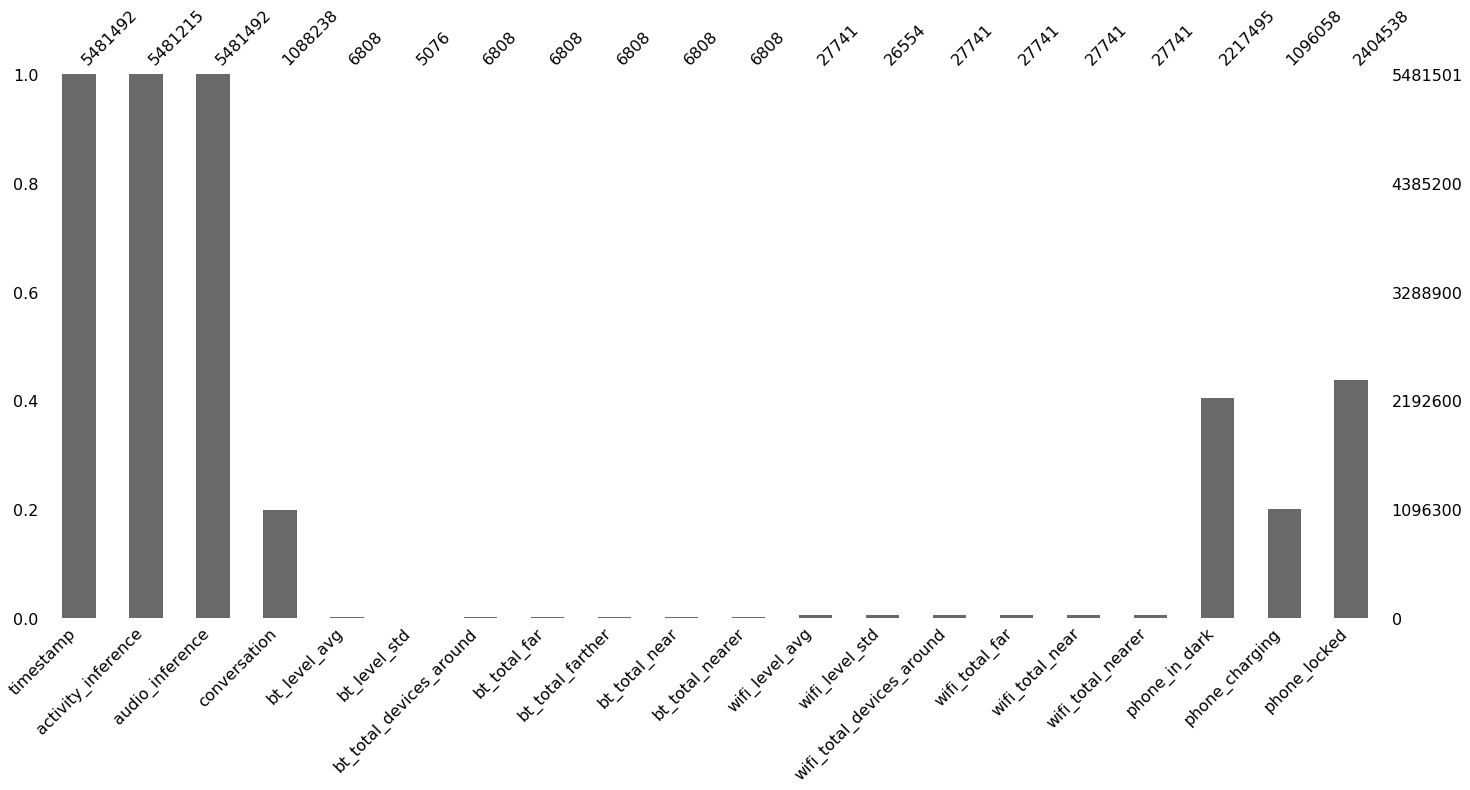

In [17]:
msno.bar(df)

# EMA

In [18]:
with open(dir_loc + 'EMA/EMA_definition.json') as f:
    definitions = json.load(f)

In [19]:
def ema(user, typ, cols):
    data = pd.read_json(dir_loc + 'EMA/response/' + typ + '/' + typ + '_' + user + '.json')
    if 'null' in data.columns:
        data = data.drop(columns='null')
    if 'location' in data.columns:
        data = data.drop(columns='location')
    if data.shape[0] != 0:
        data = data.dropna(subset=cols)
    return data

In [20]:
stress = ema(u, 'Stress', ['level'])
mood2 = ema(u, 'Mood 2', ['how'])

In [21]:
stress.head()

,level,resp_time
5,4.0,2013-03-27 20:11:23
6,5.0,2013-03-27 23:12:02
7,4.0,2013-03-27 18:35:01
8,4.0,2013-03-28 20:08:03
9,1.0,2013-03-28 22:03:36


In [22]:
mood2.head()

""


In [23]:
definitions[3]

{'name': 'Stress',
 'questions': [{'options': '[1]A little stressed, [2]Definitely stressed, [3]Stressed out, [4]Feeling good, [5]Feeling great, ',
   'question_id': 'level',
   'question_text': 'Right now, I am...'},
  {'options': '', 'question_id': 'location', 'question_text': ''}]}

In [24]:
if stress.shape[0] != 0:
    stress['level'] = stress['level'].replace([1,2,3], 1)
    stress['level'] = stress['level'].replace([4,5], 0)
    stress.columns = ['STRESSED', 'resp_time']

In [25]:
stress.head()

,STRESSED,resp_time
5,0.0,2013-03-27 20:11:23
6,0.0,2013-03-27 23:12:02
7,0.0,2013-03-27 18:35:01
8,0.0,2013-03-28 20:08:03
9,1.0,2013-03-28 22:03:36


In [26]:
definitions[17]

{'name': 'Mood 2',
 'questions': [{'options': '[1]happy, [2]stressed, [3]tired, ',
   'question_id': 'how',
   'question_text': 'How are you right now?'},
  {'options': '', 'question_id': 'location', 'question_text': ''}]}

In [27]:
if mood2.shape[0] != 0:
    mood2 = mood2.replace([1, 3], 0)
    mood2 = mood2.replace([2], 1)
    mood2.columns = ['STRESSED', 'resp_time']

In [28]:
mood2.head()

""


In [29]:
labels = stress.append(mood2)

In [30]:
labels = labels.sort_values(by='resp_time', ascending=True)

In [31]:
labels.head()

,STRESSED,resp_time
7,0.0,2013-03-27 18:35:01
5,0.0,2013-03-27 20:11:23
6,0.0,2013-03-27 23:12:02
8,0.0,2013-03-28 20:08:03
9,1.0,2013-03-28 22:03:36


In [32]:
labels_sampled = labels.set_index('resp_time').resample('3h').max()

In [33]:
labels_sampled = labels_sampled[labels_sampled.STRESSED.notnull()]

In [34]:
labels_sampled.shape

(7, 1)

In [35]:
labels_sampled.head()

,STRESSED
resp_time,
2013-03-27 18:00:00,0.0
2013-03-27 21:00:00,0.0
2013-03-28 18:00:00,0.0
2013-03-28 21:00:00,1.0
2013-03-30 00:00:00,0.0


# SENSING DATA ORGANIZE

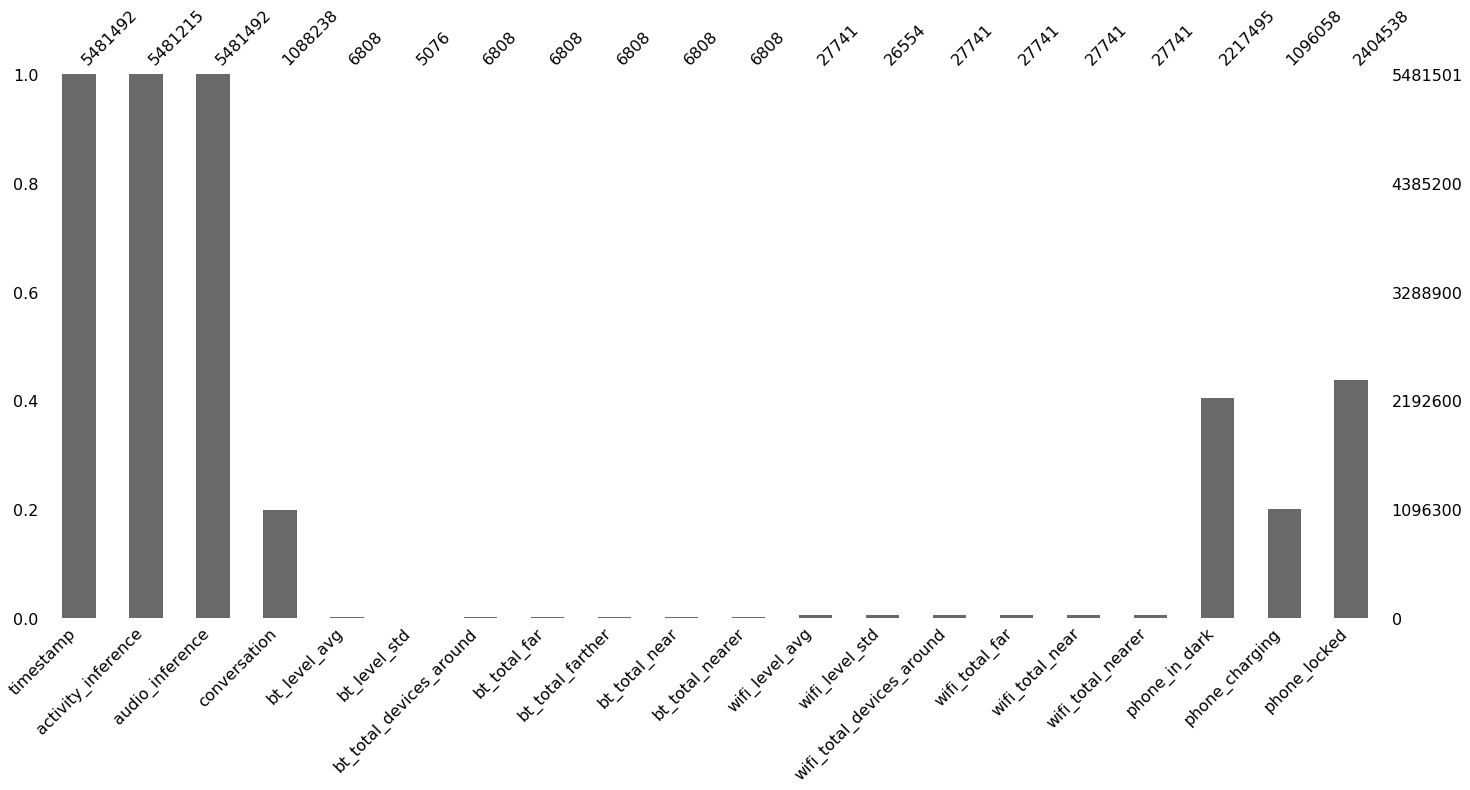

In [36]:
msno.bar(df)

In [37]:
# df.drop(df.columns[[-2, -1]], axis=1, inplace=True)

In [38]:
# df.drop(columns=['gps_accuracy',
#                  'gps_provider',
#                  'gps_network_type',
#                  'gps_latitude',
#                  'gps_longitude',
#                  'gps_altitude',
#                  'gps_bearing',
#                  'gps_speed',
#                  'gps_travelstate'], inplace=True)

In [39]:
df = df.set_index('timestamp')

In [40]:
df[['conversation',
    'phone_in_dark', 
    'phone_charging', 
    'phone_locked']] = df[['conversation',
                            'phone_in_dark', 
                            'phone_charging', 
                            'phone_locked']].fillna(value=0)

In [41]:
# -1: Unknown, 0: Stationary, 1: Walking, 2: Running
df['activity_inference'] = df['activity_inference'].replace([0,1,2,3], [0,1,2,-1])
# -1: Unknown, 0: Silence, 1: Noise, 2: Voice
df['audio_inference'] = df['audio_inference'].replace([0,1,2,3], [0,2,1,-1])

In [42]:
# def ar_mode(array):
#     return stats.mode(array)[0][0]

# df_sampled = df.resample('15min').agg({'acitiviy_inference': ar_mode, 
#                                       'audio_inference': ar_mode,
#                                       'conversation': ar_mode,
#                                       'phone_in_dark': ar_mode, 
#                                       'phone_charging': ar_mode,
#                                       'phone_locked': ar_mode,
#                                       'bt_level_avg': np.max,
#                                       'bt_level_std': np.max,
#                                       'bt_total_devices_around': np.max,
#                                       'bt_total_far': np.max,
#                                       'bt_total_farther': np.max,
#                                       'bt_total_near': np.max,
#                                       'bt_total_nearer': np.max,
#                                       'wifi_level_avg': np.max,
#                                       'wifi_level_std': np.max,
#                                       'wifi_total_devices_around': np.max,
#                                       'wifi_total_far': np.max,
#                                       'wifi_total_farther': np.max,
#                                       'wifi_total_near': np.max,
#                                       'wifi_total_nearer': np.max})

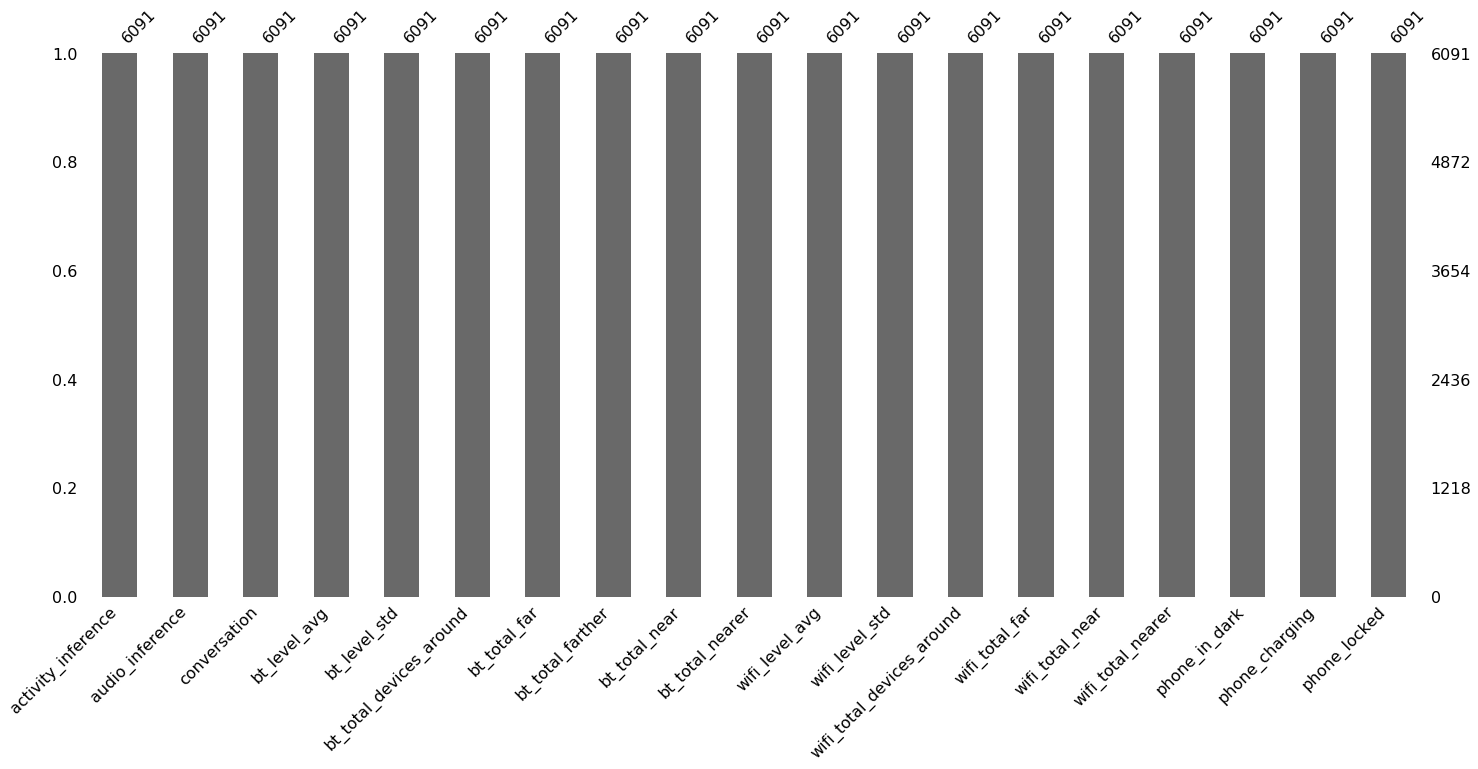

In [43]:
df_rs = df.resample('15min').sum()

msno.bar(df_rs)

In [44]:
df_rs = df_rs.fillna(0)

In [45]:
# df_rs['activity_inference'] = df_rs.activity_inference.astype('category')
# df_rs['audio_inference'] = df_rs.activity_inference.astype('category')

In [46]:
df_rs.dtypes

activity_inference           float64
audio_inference              float64
conversation                 float64
bt_level_avg                 float64
bt_level_std                 float64
bt_total_devices_around      float64
bt_total_far                 float64
bt_total_farther             float64
bt_total_near                float64
bt_total_nearer              float64
wifi_level_avg               float64
wifi_level_std               float64
wifi_total_devices_around    float64
wifi_total_far               float64
wifi_total_near              float64
wifi_total_nearer            float64
phone_in_dark                float64
phone_charging               float64
phone_locked                 float64
dtype: object

In [47]:
df_rs.shape

(6091, 19)

In [48]:
df_rs.head()

,activity_inference,audio_inference,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked
timestamp,,,,,,,,,,,,,,,,,,,
2013-03-27 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-324.0,28.689522,25.0,15.0,10.0,0.0,0.0,0.0,0.0
2013-03-27 04:15:00,0.0,118.0,0.0,-84.0,0.0,1.0,1.0,0.0,0.0,0.0,-409.0,33.554812,31.0,19.0,12.0,0.0,48.0,0.0,169.0
2013-03-27 04:30:00,0.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-317.0,38.720833,26.0,19.0,6.0,1.0,900.0,0.0,900.0
2013-03-27 04:45:00,0.0,136.0,0.0,-82.0,0.0,1.0,1.0,0.0,0.0,0.0,-239.0,29.334114,21.0,15.0,6.0,0.0,900.0,0.0,900.0
2013-03-27 05:00:00,0.0,354.0,0.0,-80.0,0.0,1.0,0.0,0.0,1.0,0.0,-323.0,40.043528,33.0,25.0,7.0,1.0,900.0,0.0,900.0


In [49]:
pd.get_dummies(df_rs).shape

(6091, 19)

In [50]:
df_rs_onehot = pd.get_dummies(df_rs)

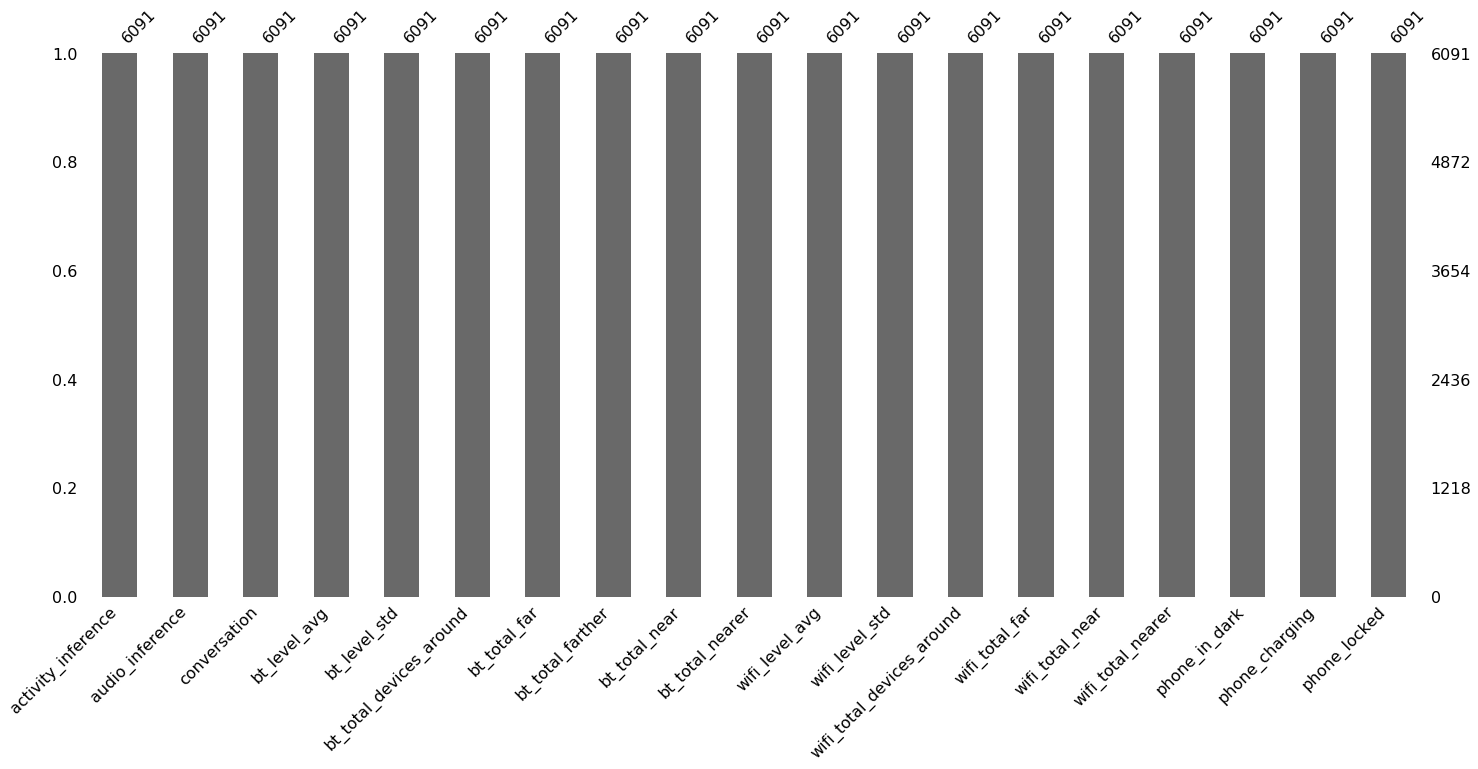

In [51]:
msno.bar(df_rs_onehot)

In [52]:
labels_sampled.tail()

,STRESSED
resp_time,
2013-03-28 18:00:00,0.0
2013-03-28 21:00:00,1.0
2013-03-30 00:00:00,0.0
2013-03-30 21:00:00,0.0
2013-03-31 06:00:00,1.0


In [53]:
a = df_rs_onehot[df_rs_onehot.index < labels_sampled.index[0]].values
a

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,  118.,    0., ...,   48.,    0.,  169.],
       [   0.,  123.,    0., ...,  900.,    0.,  900.],
       ...,
       [ -11.,  859.,  900., ...,  900.,    0.,  900.],
       [  31., 1105.,  691., ...,  900.,    0.,  900.],
       [   0., 1150.,  900., ...,  900.,    0.,  900.]])

In [54]:
b = labels_sampled.loc[labels_sampled.index[0]].values[0]
b

0.0

In [55]:
c = {'instance': a, 'label': b}
c

{'instance': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,  118.,    0., ...,   48.,    0.,  169.],
        [   0.,  123.,    0., ...,  900.,    0.,  900.],
        ...,
        [ -11.,  859.,  900., ...,  900.,    0.,  900.],
        [  31., 1105.,  691., ...,  900.,    0.,  900.],
        [   0., 1150.,  900., ...,  900.,    0.,  900.]]), 'label': 0.0}

In [56]:
z = {}
z

{}

In [57]:
z[2] = c

In [58]:
z

{2: {'instance': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,  118.,    0., ...,   48.,    0.,  169.],
         [   0.,  123.,    0., ...,  900.,    0.,  900.],
         ...,
         [ -11.,  859.,  900., ...,  900.,    0.,  900.],
         [  31., 1105.,  691., ...,  900.,    0.,  900.],
         [   0., 1150.,  900., ...,  900.,    0.,  900.]]), 'label': 0.0}}

In [59]:
df_rs_onehot.index[0]

Timestamp('2013-03-27 04:00:00')

In [60]:
def create_instances(df, labels):
    starting_label_index = 0
    
    # Finds out the timestamp of first label that have data.
    for i in range(len(labels)):
        if labels.index[i] > df.index[i]:
            starting_label_index = i
            break
        else:
            continue
        
    all_data = {}
    
    # Creates first instance of dataset.
    start = labels.index[starting_label_index]
    instance = df[df.index <= start].values
    output = labels.loc[start].values[0]
    one_data = {'instance': instance, 'label': output}
    all_data[0] = one_data
    
    # Counter that holds index of instances.
    counter = 1
    
    # Loop to create instances.
    for i in range(starting_label_index + 1, len(labels[starting_label_index:]), 1):
        end = labels.index[i]
        instance = df[(df.index > start) & (df.index <= end)].values
        if instance.shape[0] == 0:
            continue
        output = labels.loc[end].values[0]
        one_data = {'instance': instance, 'label': output}
        all_data[counter] = one_data
        start = end
        counter += 1
        
    return all_data

In [61]:
uza = create_instances(df_rs_onehot, labels_sampled)

In [64]:
uza[0]['instance'].shape

(57, 19)

In [66]:
uza[0]

{'instance': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,  118.,    0., ...,   48.,    0.,  169.],
        [   0.,  123.,    0., ...,  900.,    0.,  900.],
        ...,
        [  31., 1105.,  691., ...,  900.,    0.,  900.],
        [   0., 1150.,  900., ...,  900.,    0.,  900.],
        [   0., 1262.,  900., ...,  900.,    0.,  900.]]), 'label': 0.0}